**a. Installation et importation des bibliothèques nécessaires**

In [1]:
pip install pandas numpy wordcloud textblob nltk sklearns

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearns (from versions: none)
ERROR: No matching distribution found for sklearns


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
from sklearn.cluster import KMeans
import nltk

#nltk.download('stopwords')

**b. Chargement et préparation des données**

In [13]:
# Charger le dataset
df = pd.read_csv('fashionnova_reviews.csv')

# on affiche les infos sur les données et le debut du dataset 
df.head()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Champagne,/users/66c78240087b6269ffbcb5fb,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024"
1,Vg customer,/users/6618fdb53d4198001210cbe7,VG,3 reviews,2024-08-21T05:43:11.000Z,Rated 5 out of 5 stars,Top tier content for fashion nova,Always amazing clothes and the fast shipping i...,"August 18, 2024"
2,Colleen Burgher,/users/64e9595206be1a001244ff73,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024"
3,R.G.M,/users/66c58ad1c6ab36352a08f57a,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024"
4,Rosalyn Cousar,/users/60ad4b6ef3788e001adbb8e3,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024"


In [29]:
# Nettoyer les données
df = df.dropna(subset=['Review Text', 'Rating'])

# Remplacer les valeurs manquantes
df['Country'] = df['Country'].fillna('Unknown')
df['Reviewer Name'] = df['Reviewer Name'].fillna('Unknown')
df['Review Title'] = df['Review Title'].fillna('No Title')

# Convertir les colonnes de date en format datetime avec le format spécifié
df['Review Date'] = pd.to_datetime(df['Review Date'], format='%Y-%m-%d')  # Ajustez le format selon vos données
df['Date of Experience'] = pd.to_datetime(df['Date of Experience'], format='%Y-%m-%d')

# Obtenir la date de début et de fin
date_debut = df['Review Date'].min()
date_fin = df['Review Date'].max()

print(f"Date de début du dataset : {date_debut}")
print(f"Date de fin du dataset : {date_fin}")

# Extraire le mois et l'année de la colonne 'Review Date'
df['Review Month'] = df['Review Date'].dt.to_period('M')

# Extraire la note (nombre d'étoiles) à partir de la colonne Rating
df['Stars'] = df['Rating'].str.extract(r'(\d+)').astype(int)

# Nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()
print(missing_values)

Date de début du dataset : 2016-11-27 19:54:08+00:00
Date de fin du dataset : 2024-08-23 00:59:57+00:00


C:\Users\pc cam\AppData\Local\Temp\ipykernel_1744\2573679342.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Review Month'] = df['Review Date'].dt.to_period('M')


Reviewer Name               0
Profile Link                0
Country                     0
Review Count                0
Review Date                 0
Rating                      0
Review Title                0
Review Text                 0
Date of Experience          0
Review Month                0
Stars                       0
Sentiment                   0
Cleaned Text                0
Keywords                    0
Normalized Stars            0
Sentiment Score             0
Review Length               0
Normalized Review Length    0
Desirability Index          0
Country Grouped             0
dtype: int64


**c. Distribution des notes pour les 10 pays avec le plus grand nombre de note**

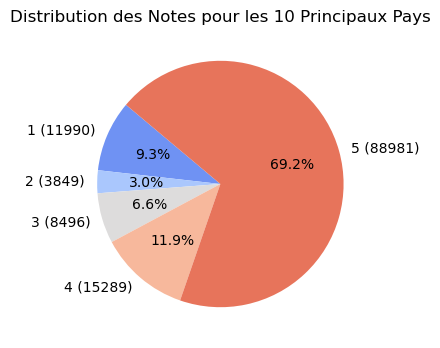

In [15]:
# Filtrer les 10 pays avec le plus grand nombre de notes
top_countries = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries)]

# Calculer la distribution des notes pour ces pays
note_distribution = filtered_df.groupby('Country')['Stars'].value_counts().unstack().fillna(0)

# Préparer les données pour le graphique
note_distribution = note_distribution.sum(axis=0)  # Somme des notes pour chaque catégorie
labels = [f'{note} ({count})' for note, count in note_distribution.items()]

# Définir une palette de couleurs
palette = sns.color_palette('coolwarm', n_colors=len(note_distribution))

# Créer le graphique en camembert
plt.figure(figsize=(6, 4))
plt.pie(note_distribution, labels=labels, autopct='%1.1f%%', colors=palette, startangle=140)
plt.title('Distribution des Notes pour les 10 Principaux Pays')
plt.show()

le graphique qui suit illustre la répartition des notes attribuées par les utilisateurs dans les 10 pays ayant le plus grand nombre d'avis. On utilise un graphique en violon pour visualiser la distribution des notes pour chaque pays.

Détails du Graphique

- **Graphique en Violon** : Le graphique en violon montre la distribution des notes (**Stars**) pour chaque pays. La forme du violon permet de visualiser la densité des notes ainsi que leur variation pour chaque pays.
- **Points de Densité** : Les points noirs ajoutés au graphique (avec une légère transparence) montrent la densité des notes. Chaque point représente une note individuelle, permettant de voir comment les notes sont réparties pour chaque pays.

Analyse

- **Comparaison des Pays** : Le graphique permet de comparer la distribution des notes entre les pays. Vous pouvez observer des variations dans les formes des violons, ce qui indique des différences dans la manière dont les notes sont distribuées.
- **Densité des Notes** : Les points noirs offrent une vue détaillée de la concentration des notes, vous aidant à identifier les tendances ou les anomalies spécifiques dans chaque pays.

Utilité

Ce graphique est utile pour :
- **Comparer la Répartition des Notes** : Visualiser comment les notes varient d'un pays à l'autre et détecter des tendances ou des anomalies.
- **Analyser la Satisfaction** : Comprendre la satisfaction des utilisateurs dans les pays les plus actifs en termes d'avis, ce qui peut fournir des insights précieux pour améliorer les services.


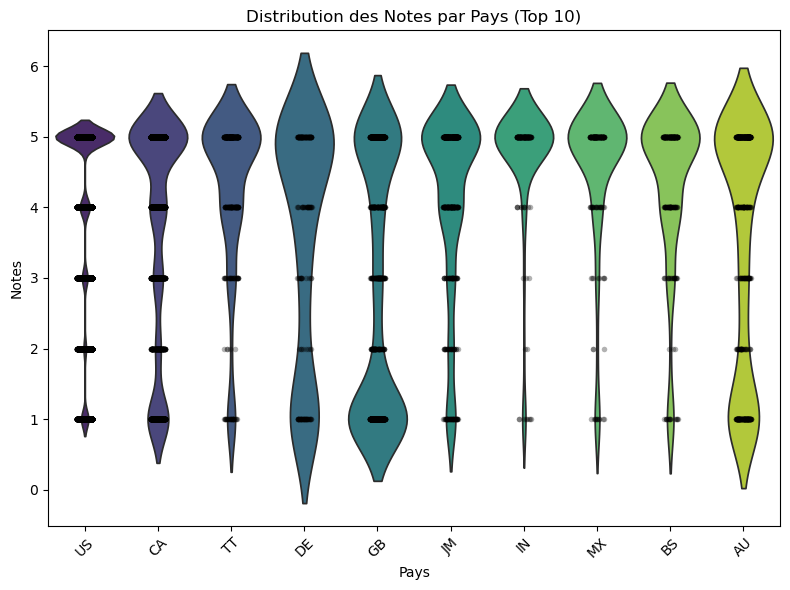

In [34]:
# Filtrer les 10 pays avec le plus grand nombre de notes
top_countries = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries)]

# Créer le graphique en violon
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='Country', y='Stars', data=filtered_df, hue='Country', palette='viridis', inner=None)

# Ajouter des points pour la densité des notes
sns.stripplot(x='Country', y='Stars', data=filtered_df, color='k', alpha=0.3, size=4, jitter=True)

plt.title('Distribution des Notes par Pays (Top 10)')
plt.xlabel('Pays')
plt.ylabel('Notes')
plt.xticks(rotation=45)
plt.tight_layout()  # toujours Ajuster le layout pour éviter les chevauchements
plt.show()

**d- Évolution de la Satisfaction Moyenne au Fil du Temps**

Ce graphique montre l'évolution de la satisfaction moyenne des utilisateurs sur une période donnée. Les données sont agrégées par mois pour illustrer comment la satisfaction moyenne a changé au fil du temps.

Détails du Graphique

- **Courbe de Satisfaction Moyenne** : La courbe représente la moyenne des notes (**Stars**) données par les utilisateurs chaque mois. Les points marqués sur la courbe indiquent les valeurs de satisfaction moyenne pour chaque mois.
- **Axes** :
  - **Axe X (Date)** : Montre les dates avec des ticks principaux pour chaque année et des ticks mineurs pour chaque mois. Les dates sont formatées pour afficher uniquement l'année afin d'améliorer la lisibilité.
  - **Axe Y (Satisfaction moyenne)** : Représente la moyenne des notes attribuées, mesurée en étoiles. La courbe illustre les variations de cette moyenne au fil des mois.

Analyse

- **Tendances dans le Temps** : La courbe permet de visualiser les tendances générales de la satisfaction au fil des mois. Vous pouvez identifier des périodes de hausse ou de baisse significative de la satisfaction.
- **Variations Mensuelles** : Les points sur la courbe montrent les valeurs exactes de satisfaction pour chaque mois, ce qui permet d'examiner plus en détail les fluctuations mensuelles.
  
Ce graphique est utile pour :
- **Observer les Tendances** : Identifier les périodes où la satisfaction des utilisateurs a augmenté ou diminué.
- **Prendre des Décisions** : Utiliser les tendances pour ajuster les stratégies et améliorer les aspects qui affectent la satisfaction des utilisateurs.


C:\Users\pc cam\AppData\Local\Temp\ipykernel_1744\670930770.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  satisfaction_mensuelle = df.groupby(df['Review Date'].dt.to_period('M'))['Stars'].mean()


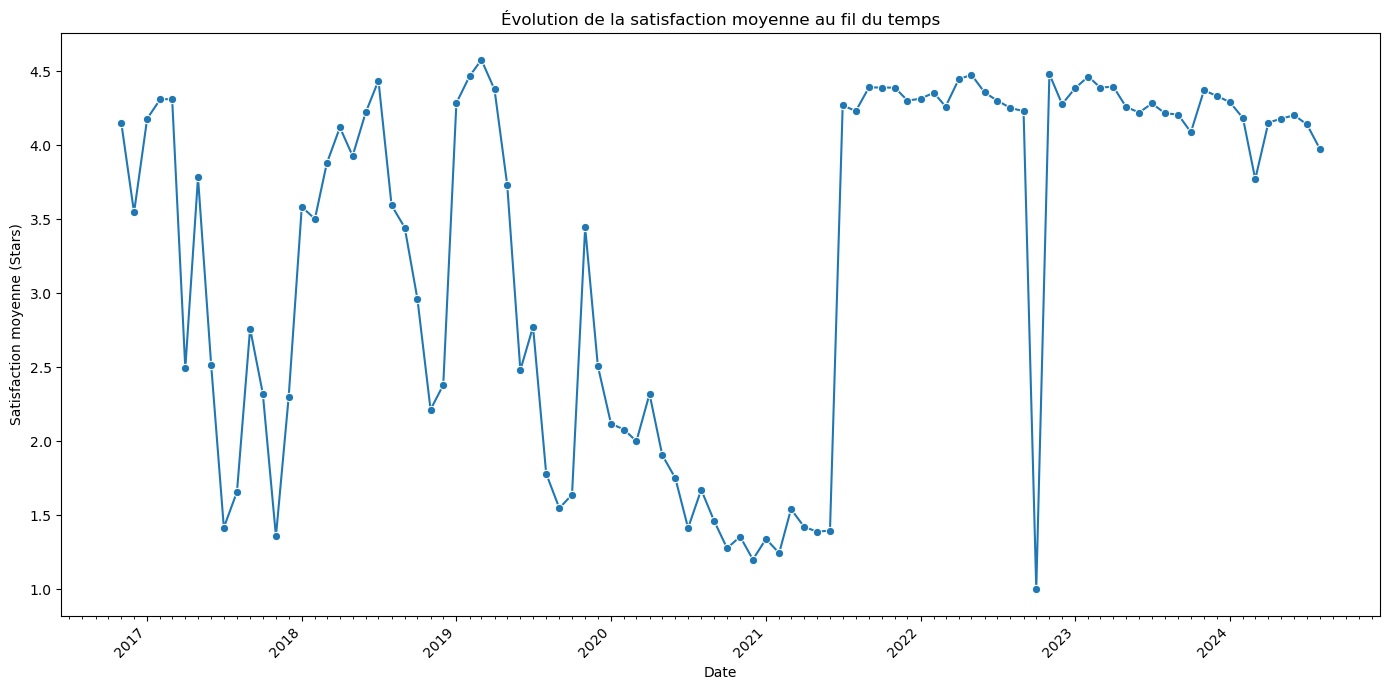

In [17]:
# On regroupe les données par mois et on calcule la satisfaction moyenne pour chaque mois
satisfaction_mensuelle = df.groupby(df['Review Date'].dt.to_period('M'))['Stars'].mean()

# On convertit l'index des périodes mensuelles en dates
satisfaction_mensuelle.index = satisfaction_mensuelle.index.to_timestamp()

# On prépare les données pour Seaborn : on crée un DataFrame avec des colonnes adaptées
df_plot = satisfaction_mensuelle.reset_index()
df_plot.columns = ['Date', 'Satisfaction']  # Renommons les colonnes pour qu'elles soient claires

# On crée notre graphique avec une taille qui permettra une bonne visibilité
plt.figure(figsize=(14, 7))

# On trace la courbe de satisfaction moyenne avec des points marqués pour chaque mois
sns.lineplot(data=df_plot, x='Date', y='Satisfaction', marker='o')

# On ajuste les dates sur l'axe X pour rendre le tout plus lisible
ax = plt.gca()  # On récupère l'axe actuel pour le personnaliser
ax.xaxis.set_major_locator(mdates.YearLocator())  # On met un tick principal pour chaque année
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # On ajoute des ticks mineurs pour chaque mois
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # On formate les ticks pour afficher l'année seulement

# On incline les étiquettes des dates pour qu'elles ne se chevauchent pas et soient plus lisibles
plt.xticks(rotation=45, ha='right')

# On ajoute un titre et des labels pour rendre le graphique plus compréhensible
plt.title('Évolution de la satisfaction moyenne au fil du temps')
plt.xlabel('Date')  # Label pour l'axe des X
plt.ylabel('Satisfaction moyenne (Stars)')  # Label pour l'axe des Y

# On ajuste les marges pour que tout soit bien visible et pas trop serré
plt.tight_layout()

# On affiche le graphique final
plt.show()

**e. Analyse des sentiments**

Dans cette section, nous analysons les sentiments exprimés dans les avis en utilisant l'analyse de sentiment basée sur la bibliothèque TextBlob. Les avis sont classifiés en trois catégories : Positif, Neutre et Négatif, selon le score de polarité calculé pour chaque texte d'avis.

Fonction d'Analyse des Sentiments

- **Fonction `get_sentiment(text)`** : Cette fonction prend en entrée un texte d'avis, utilise TextBlob pour déterminer la polarité du sentiment et retourne une classification :
  - **Positif** : Lorsque la polarité est supérieure à 0.
  - **Neutre** : Lorsque la polarité est égale à 0.
  - **Négatif** : Lorsque la polarité est inférieure à 0.

     La fonction est appliquée à chaque avis dans le DataFrame, créant une nouvelle colonne intitulée 'Sentiment' qui contient la classification du sentiment pour chaque avis.

Cette analyse est utile pour :
- **Comprendre les Opinions** : Avoir un aperçu général de la manière dont les utilisateurs perçoivent le produit ou le service.
- **Prendre des Décisions** : Utiliser les insights obtenus pour ajuster les stratégies ou améliorer les aspects du produit/service en fonction des sentiments exprimés.


C:\Users\pc cam\AppData\Local\Temp\ipykernel_1744\2853990974.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


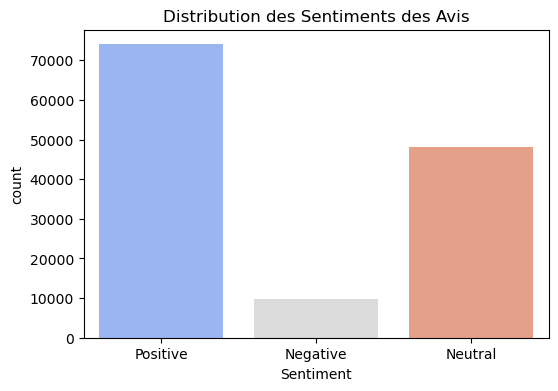

In [18]:
# definissons une Fonction pour analyser les sentiments
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Appliquons maintenant l'analyse des sentiments
df['Sentiment'] = df['Review Text'].apply(get_sentiment)

# Distribution des sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Distribution des Sentiments des Avis')
plt.show()

**f. Analyse des mots-clés**

Cette section se concentre sur l'analyse des mots-clés présents dans les avis pour différencier les avis positifs des avis négatifs. Nous utilisons des nuages de mots pour visualiser les mots les plus fréquemment utilisés dans chaque catégorie de sentiment.

Préparation du Texte

1. **Nettoyage du Texte** :
   - Les textes des avis sont convertis en minuscules.
   - Les signes de ponctuation et les caractères spéciaux sont supprimés.

Ce nettoyage aide à préparer les textes pour l'extraction des mots-clés.

2. **Extraction des Mots-Clés** :
   - **Fonction `extract_keywords(text)`** : Cette fonction divise le texte en mots, supprime les mots courants (stop words) et renvoie les mots restants.
   - Les mots clés extraits sont stockés dans une nouvelle colonne `'Keywords'`.

Génération des Nuages de Mots : 

**Nuage de Mots pour les Avis Positifs/Négatifs** :
 Les avis classifiés sont concaténés en un seul texte. Un nuage de mots est créé à partir de ce texte, affichant les mots les plus fréquents en utilisant une palette de couleurs blanche pour le fond.

Cette analyse est utile pour : 

- **Identification des Thèmes** : Cette analyse aide à identifier les thèmes ou les aspects du produit qui sont le plus souvent mentionnés dans les avis positifs ou négatifs.
- **Amélioration** : Les insights obtenus peuvent être utilisés pour améliorer le produit ou le service en mettant en avant les points forts et en adressant les problèmes fréquemment rencontrés.


<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\pc cam\AppData\Local\Temp\ipykernel_1744\2749729056.py:3: SyntaxWarning: invalid escape sequence '\w'
  df['Cleaned Text'] = df['Review Text'].str.lower().str.replace('[^\w\s]','')


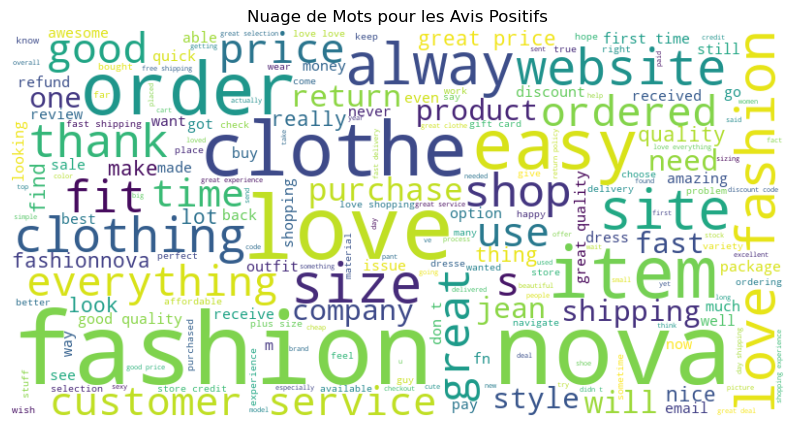

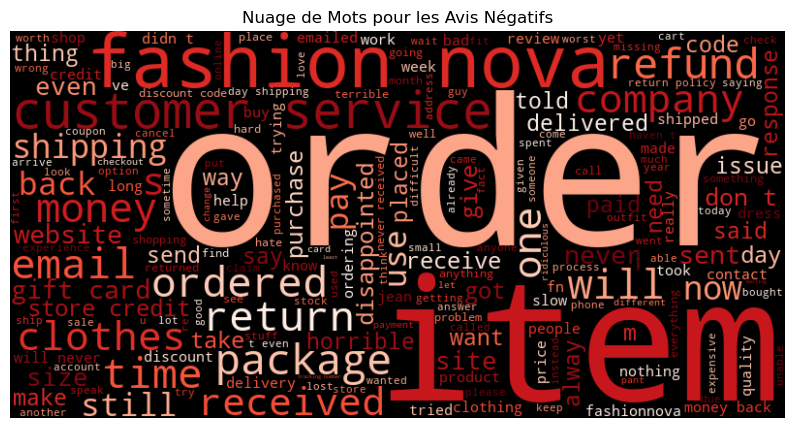

In [19]:
# Préparer le texte pour l'analyse des mots-clés pour distinguer les avis positifs des avis négatifs 
stop_words = set(stopwords.words('english'))
df['Cleaned Text'] = df['Review Text'].str.lower().str.replace('[^\w\s]','')

# Fonction pour extraire les mots-clés
def extract_keywords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

# Appliquer l'extraction des mots-clés
df['Keywords'] = df['Cleaned Text'].apply(extract_keywords)

# Générer un nuage de mots pour les avis positifs
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Cleaned Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Avis Positifs')
plt.show()

# Nuage de mots pour les avis négatifs
negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['Cleaned Text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Avis Négatifs')
plt.show()

**g. Analyse temporelle**

Ici on visualise la répartition des avis en fonction des sentiments exprimés, mois par mois. Nous ajoutons d'abord une colonne pour les catégories de sentiments dans notre DataFrame, puis nous créons une table de contingence pour regrouper les avis par mois et par sentiment. Enfin, nous générons un graphique en barres empilées pour illustrer ces données.

**Étapes détaillé de l'Analyse** 

1. **Ajouter une Colonne pour les Catégories de Sentiments** :
   - **Fonction `get_sentiment`** : Cette fonction analyse le texte des avis pour déterminer le sentiment (positif, neutre ou négatif).
   - **Application de la Fonction** : Nous appliquons cette fonction à la colonne `'Review Text'` pour créer une nouvelle colonne `'Sentiment'` dans le DataFrame `df`.

2. **Créer une Table de Contingence** :
   - **Table de Contingence** : Une table de contingence est créée pour compter le nombre d'avis de chaque sentiment par mois.
   - **Pivot Table** : Utilisation de `pivot_table` pour compter le nombre d'avis pour chaque combinaison de mois et de sentiment. Les valeurs manquantes sont remplacées par 0.

3. **Créer le Graphique en Barres Empilées** :
Nous générons un graphique en barres empilées pour visualiser la répartition des sentiments par mois. Ce graphique montre la répartition des avis positifs, neutres et négatifs pour chaque mois. Les barres empilées permettent de voir facilement comment les sentiments varient au fil du temps.

cette analyse est utile pour : 

- **Analyse Temporelle des Sentiments** : Ce graphique aide à comprendre les tendances des sentiments dans les avis au fil des mois, ce qui peut fournir des insights sur l'évolution des perceptions des clients.
- **Identification des Périodes** : Il est possible d'identifier des périodes spécifiques où les avis sont particulièrement positifs ou négatifs, ce qui peut être utile pour enquêter sur les événements ou changements qui ont pu influencer ces sentiments.


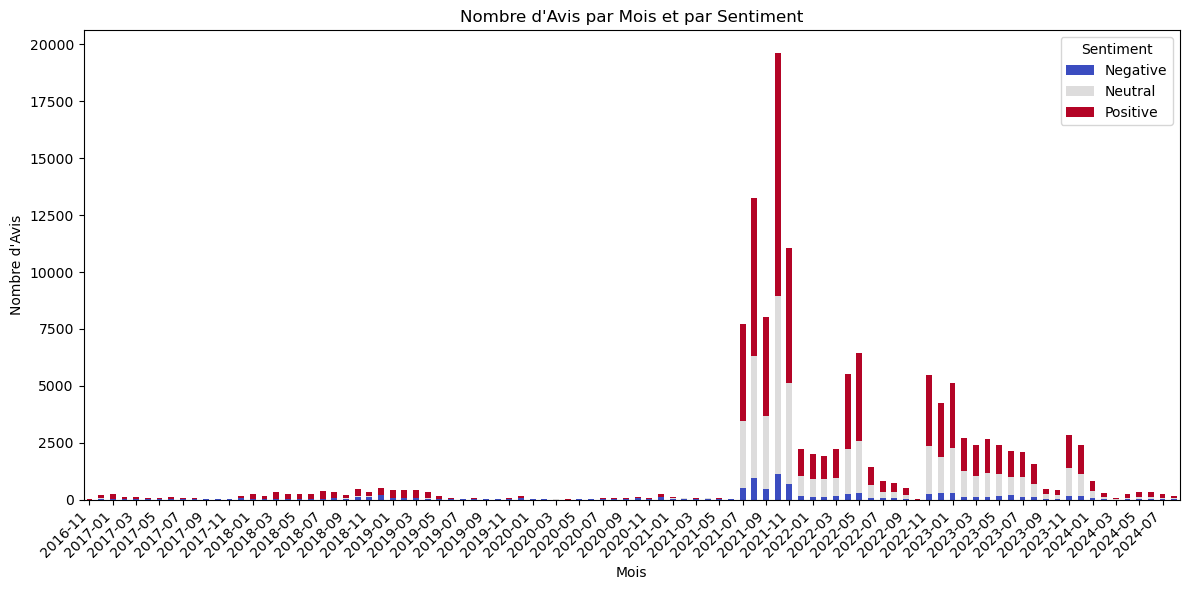

In [20]:
# Ajouter une colonne pour les catégories de sentiments
df['Sentiment'] = df['Review Text'].apply(get_sentiment)

# Créer une table de contingence pour les sentiments par mois
pivot_table = df.pivot_table(index='Review Month', columns='Sentiment', aggfunc='size', fill_value=0)

# Créer le graphique en barres empilées
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Ajuster les étiquettes de l'axe x
plt.title('Nombre d\'Avis par Mois et par Sentiment')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'Avis')

# Rotation et format des dates
ax.set_xticks(ax.get_xticks()[::2])  # Afficher une étiquette sur deux
ax.set_xticklabels([str(tick) for tick in pivot_table.index[::2]])  # Utiliser simplement les mois comme chaîne de caractères

plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes des mois pour meilleure lisibilité
plt.legend(title='Sentiment')
plt.tight_layout()  # Ajuster automatiquement les paramètres de sous-figures pour éviter le chevauchement
plt.show()

**h. Définition de l'Indice de Désirabilité**

**L'indice de désirabilité** pourrait être défini comme une combinaison pondérée des éléments suivants :

- Note (étoiles) : Une évaluation directe du produit ou du service, sur une échelle de 1 à 5.
- Sentiment : Une analyse du ton de l'avis (positif, négatif, neutre).
- Longueur de l'avis : Une mesure du détail dans l'avis, car un avis plus long pourrait indiquer un engagement plus profond, qu'il soit positif ou négatif.

**Étapes de l'Analyse**

1. **Calcul des Corrélations Absolues** :
   - **Matrice de Corrélations** : On calcule la matrice de corrélations entre les variables pour comprendre la relation entre elles.
   - **Valeurs Absolues** : On prend les valeurs absolues des corrélations pour éviter les effets de signe et se concentrer uniquement sur la force des relations.

2. **Calcul des Poids** :
   - **Somme des Corrélations** : On calcule la somme des valeurs absolues des corrélations pour chaque variable afin d'obtenir une mesure globale de leur influence.
   - **Normalisation** : Les poids sont normalisés pour que leur somme totale soit égale à 1, ce qui permet d'utiliser ces poids dans un calcul proportionnel.

3. **Calcul de l'Indice de Désirabilité** :
   - **Formule** : L'indice est calculé en multipliant les valeurs normalisées des variables par leurs poids respectifs et en les additionnant.
   - **Variables Utilisées** : Les variables incluent `'Normalized Stars'`, `'Sentiment Score'`, et `'Normalized Review Length'`.

4. **Visualisation de la Distribution** :
  Ce graphique illustre comment l'indice de désirabilité est réparti dans l'ensemble de données. La courbe KDE permet de visualiser la densité de l'indice et d'identifier les valeurs les plus fréquentes.

cette analyse est Utile pour : 

- **Analyse de la Désirabilité** : Cette visualisation aide à comprendre la distribution de l'indice de désirabilité parmi les observations. Cela peut fournir des insights sur les niveaux généraux de désirabilité et aider à identifier les segments avec des indices particulièrement élevés ou faibles.
- **Interprétation des Poids** : En analysant la distribution, on peut aussi évaluer l'impact relatif des différentes variables sur l'indice de désirabilité et ajuster les poids ou les variables si nécessaire pour affiner l'analyse.


**Matrice de correlation**

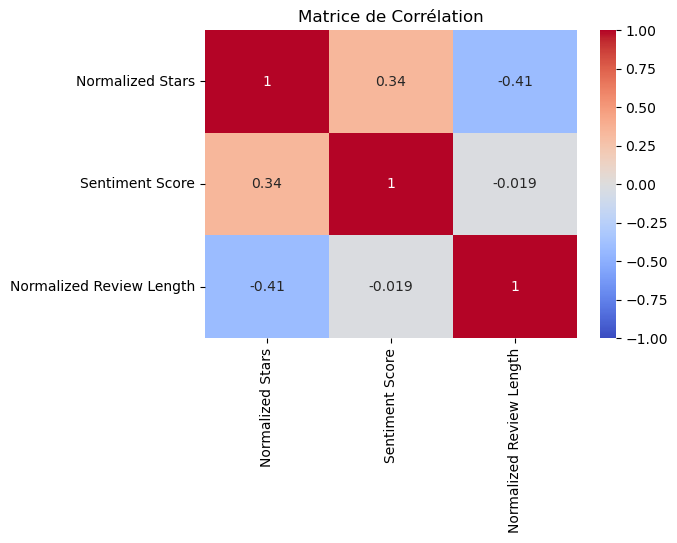

In [25]:

# Sélectionner les colonnes pertinentes pour l'analyse
columns = ['Normalized Stars', 'Sentiment Score', 'Normalized Review Length']

# Normalisation de la note sur une échelle de 0 à 1
df['Normalized Stars'] = df['Stars'] / 5

# Conversion des sentiments en scores
sentiment_mapping = {'Positive': 1, 'Neutral': 0.5, 'Negative': 0}
df['Sentiment Score'] = df['Sentiment'].map(sentiment_mapping)

# Longueur de l'avis
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))
# Normalisation de la longueur de l'avis sur une échelle de 0 à 1
df['Normalized Review Length'] = df['Review Length'] / df['Review Length'].max()

# Calculer la matrice de corrélation
corr_matrix = df[columns].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()


**Création de l'indice**

In [26]:
# Prendre les valeurs absolues des corrélations avec chaque variable
abs_corr = corr_matrix.abs()

# Calculer la somme des corrélations pour chaque variable (somme des valeurs absolues des corrélations)
weight_sums = abs_corr.sum()

# Normaliser les poids pour qu'ils totalisent 1
weights = weight_sums / weight_sums.sum()

# Calculer l'indice de désirabilité en utilisant les poids basés sur les corrélations
df['Desirability Index'] = (
    weights['Normalized Stars'] * df['Normalized Stars'] +
    weights['Sentiment Score'] * df['Sentiment Score'] +
    weights['Normalized Review Length'] * df['Normalized Review Length']
)

**Visualisation et analyse de l'indice**

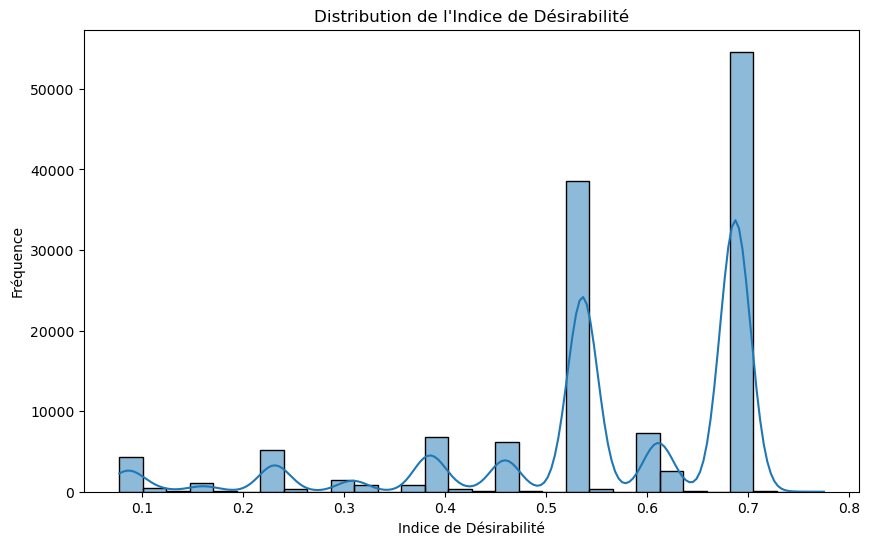

In [27]:
# Visualiser la distribution de l'indice de désirabilité
plt.figure(figsize=(10, 6))
sns.histplot(df['Desirability Index'], bins=30, kde=True)
plt.title('Distribution de l\'Indice de Désirabilité')
plt.xlabel('Indice de Désirabilité')
plt.ylabel('Fréquence')
plt.show()


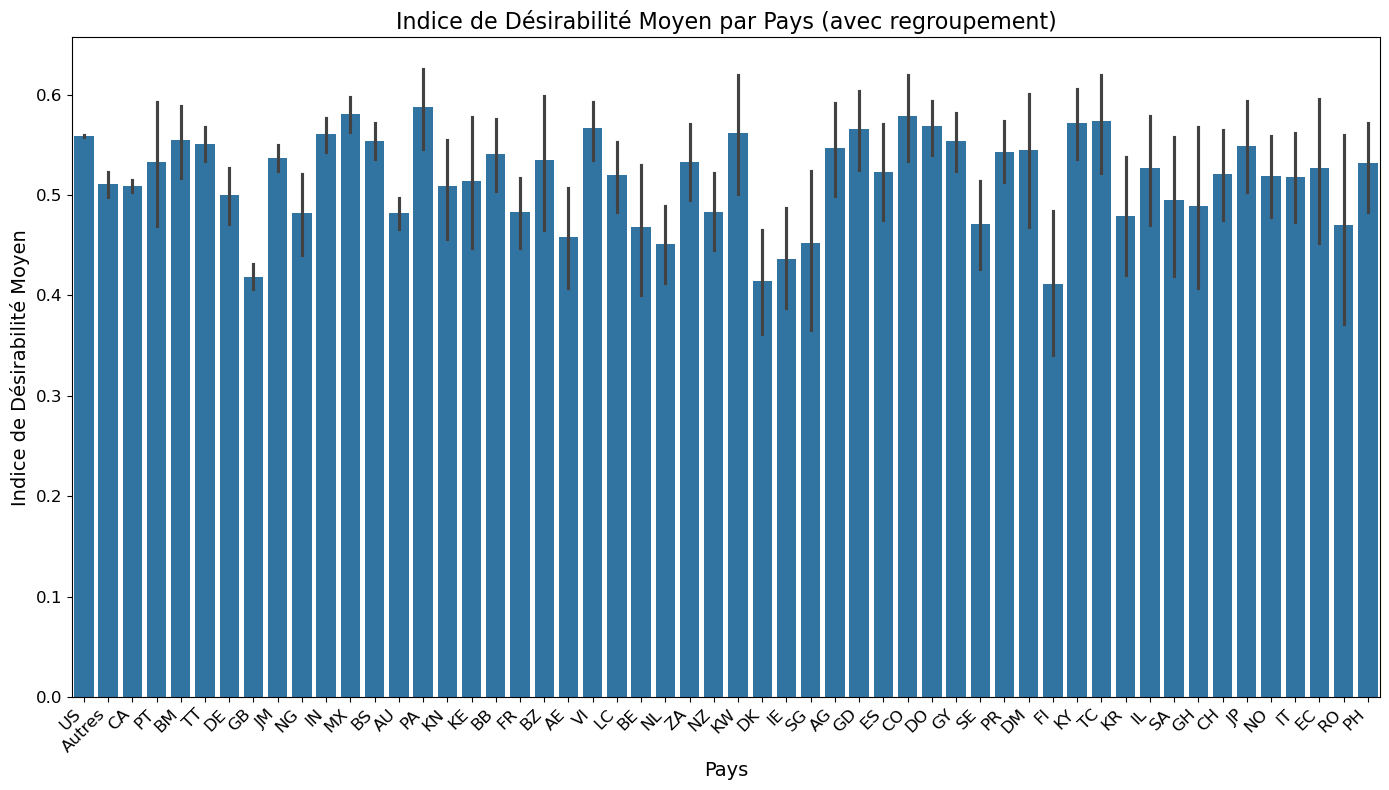

In [35]:
# Définir un seuil pour regrouper les pays avec peu d'avis
threshold = 20  

# Créer une nouvelle colonne pour regrouper les petits pays
df['Country Grouped'] = df['Country'].apply(lambda x: x if df['Country'].value_counts()[x] > threshold else 'Autres')

# Créer le graphique
plt.figure(figsize=(14, 8))  # Augmenter la taille de la figure
sns.barplot(x='Country Grouped', y='Desirability Index', data=df, estimator='mean')

# Ajouter des labels et un titre clairs
plt.title('Indice de Désirabilité Moyen par Pays (avec regroupement)', fontsize=16)
plt.xlabel('Pays', fontsize=14)
plt.ylabel('Indice de Désirabilité Moyen', fontsize=14)

# Ajuster les étiquettes des axes pour améliorer la lisibilité
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Ajuste le layout pour éviter le chevauchement
plt.show()

Ce graphique illustre l'indice de désirabilité moyen par pays, avec des barres d'erreur verticales indiquant la variabilité autour de chaque moyenne. Voici comment comprendre ces éléments :

**Barres d'Erreur Verticales** :
Les barres d'erreur verticales montrent la mesure de la dispersion ou de l'incertitude autour de la valeur moyenne de l'indice de désirabilité pour chaque pays. Elles peuvent représenter des intervalles de confiance ou des écarts-types.

Ces barres permettent de visualiser la précision des moyennes affichées. Une barre plus longue indique une plus grande variabilité des indices de désirabilité et moins de certitude quant à la valeur moyenne, tandis qu'une barre plus courte indique une plus grande stabilité.